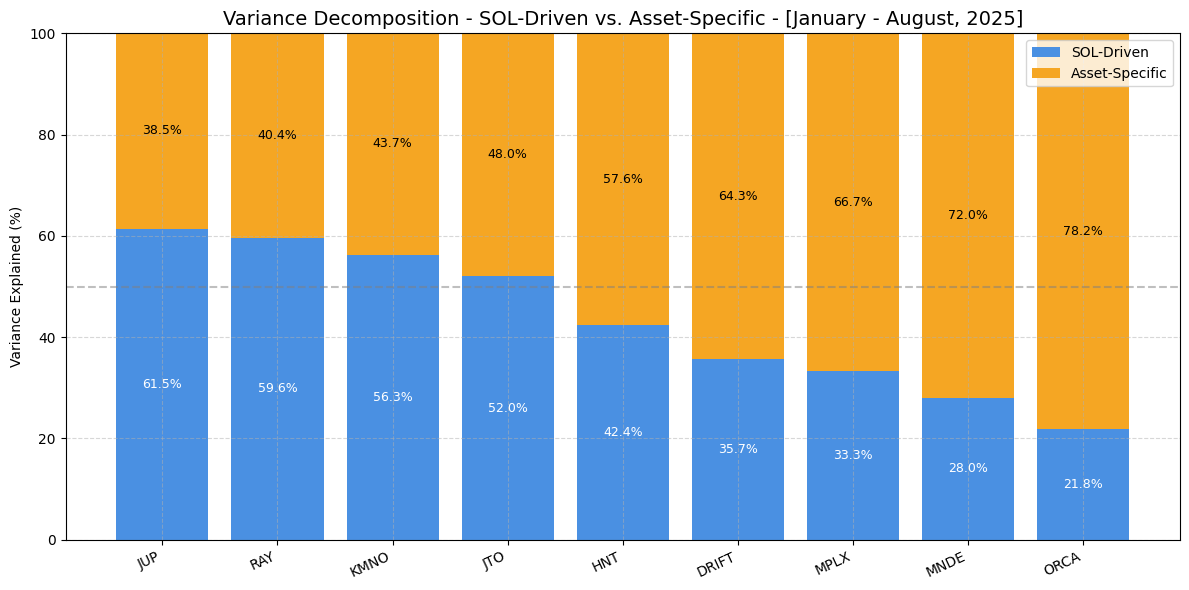

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

raw_prices_df = pd.read_csv("variance-decomposition-solana.csv", sep=",")
raw_prices_df.iloc[:, 0] = pd.to_datetime(raw_prices_df.iloc[:, 0], utc=True)
raw_prices_df.columns = [raw_prices_df.columns[0]] + [c.strip().lower() for c in raw_prices_df.columns[1:]]
raw_prices_df = raw_prices_df.sort_values(raw_prices_df.columns[0])
price_cols = [c for c in raw_prices_df.columns[1:] if c != ""]

numeric_prices_df = raw_prices_df.copy()
for c in price_cols:
    numeric_prices_df[c] = pd.to_numeric(numeric_prices_df[c], errors="coerce")

log_prices_df = numeric_prices_df.set_index(numeric_prices_df.columns[0]).apply(np.log)
returns_df = log_prices_df.diff().dropna()

if "sol" not in returns_df.columns:
    raise ValueError("Expected a 'sol' column for the benchmark.")

sol_returns = returns_df["sol"].rename("ret_bench")
altcoin_cols = [c for c in returns_df.columns if c != "sol"]

r2_list = []
for col in altcoin_cols:
    y = returns_df[col].dropna()
    X = sol_returns.reindex(y.index).dropna()
    y = y.reindex(X.index)
    X_design = sm.add_constant(X.values)
    model = sm.OLS(y.values, X_design).fit()
    r2_list.append((col.upper(), float(model.rsquared)))

decomp_df = pd.DataFrame(r2_list, columns=["asset", "r2"]).assign(
    sol_driven_pct=lambda d: d["r2"]*100.0,
    asset_specific_pct=lambda d: 100.0 - d["sol_driven_pct"]
)
decomp_df = decomp_df.sort_values("sol_driven_pct", ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(decomp_df))

sol_color = "#4A90E2"
asset_color = "#F5A623"

ax.bar(x, decomp_df["sol_driven_pct"], label="SOL-Driven", color=sol_color)
ax.bar(x, decomp_df["asset_specific_pct"], bottom=decomp_df["sol_driven_pct"], label="Asset-Specific", color=asset_color)

ax.axhline(50, linestyle="--", color="gray", alpha=0.5)
ax.set_xticks(x)
ax.set_xticklabels(decomp_df["asset"], rotation=25, ha="right")
ax.set_ylabel("Variance Explained (%)")
ax.set_title("Variance Decomposition - SOL-Driven vs. Asset-Specific - [January - August, 2025]", fontsize=14)
ax.set_ylim(0, 100)
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

for xi, s, a in zip(x, decomp_df["sol_driven_pct"], decomp_df["asset_specific_pct"]):
    ax.text(xi, s/2, f"{s:.1f}%", ha="center", va="center", fontsize=9, color="white")
    ax.text(xi, s + a/2, f"{a:.1f}%", ha="center", va="center", fontsize=9)

plt.tight_layout()
plt.show()

In [32]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

alpha = 0.05
rows = []
for col in altcoin_cols:
    y = returns_df[col].dropna()
    X = sol_returns.reindex(y.index).dropna()
    y = y.reindex(X.index)
    X_design = sm.add_constant(X.values)
    model = sm.OLS(y.values, X_design).fit()
    robust = model.get_robustcov_results(cov_type="HC1")
    beta = float(model.params[1])
    pval = float(robust.pvalues[1])
    r2 = float(model.rsquared)
    r = np.sign(beta) * np.sqrt(r2)
    rows.append((col.upper(), pval, beta, r, len(y)))

reg_stats_df = pd.DataFrame(rows, columns=["asset","p_value","beta_sol","correlation_r","n_obs"])
reg_stats_df["sol_driven_pct"] = (reg_stats_df["correlation_r"]**2) * 100.0
reg_stats_df["asset_specific_pct"] = 100.0 - reg_stats_df["sol_driven_pct"]

sig_df = reg_stats_df.query("p_value < @alpha").reset_index(drop=True)
sig_assets = sig_df["asset"].tolist()

reg_stats_df

,asset,p_value,beta_sol,correlation_r,n_obs,sol_driven_pct,asset_specific_pct
0,HNT,5.958580e-22,0.775249,0.650993,223,42.379234,57.620766
1,JTO,4.739989e-32,0.828338,0.721048,223,51.990998,48.009002
2,JUP,2.218392e-26,1.029758,0.783937,223,61.455757,38.544243
3,KMNO,1.671183e-42,1.085997,0.750305,223,56.295707,43.704293
4,MPLX,6.549729e-18,0.609497,0.577016,223,33.294801,66.705199
5,ORCA,1.882814e-16,0.857985,0.466859,223,21.795730,78.204270
6,RAY,7.187975e-38,1.162418,0.771767,223,59.562498,40.437502
7,MNDE,6.288016e-21,0.967364,0.529441,223,28.030796,71.969204
8,DRIFT,3.650758e-16,0.758122,0.597254,223,35.671265,64.328735


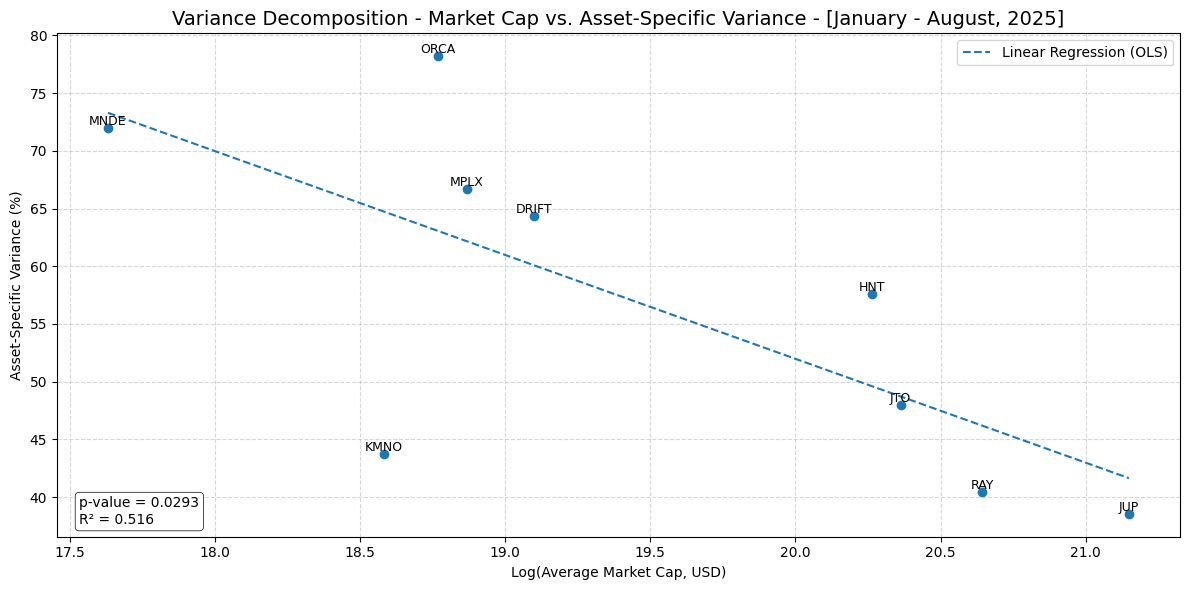

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

mcap_df = pd.read_csv("variance-decomposition-solana-marketcap.csv", thousands=",")
mcap_df.iloc[:, 0] = pd.to_datetime(mcap_df.iloc[:, 0], utc=True)
mcap_df.columns = [mcap_df.columns[0]] + [c.strip().lower() for c in mcap_df.columns[1:]]

mcap_num = mcap_df.drop(columns=mcap_df.columns[0]).apply(pd.to_numeric, errors="coerce")
avg_mcap = mcap_num.mean(axis=0).rename_axis("asset").reset_index(name="avg_market_cap")
avg_mcap["asset"] = avg_mcap["asset"].str.upper()

merged_df = decomp_df.merge(avg_mcap, on="asset", how="left").dropna(subset=["avg_market_cap"])

X = sm.add_constant(np.log(merged_df["avg_market_cap"]))
y = merged_df["asset_specific_pct"]
model = sm.OLS(y, X).fit()

fig, ax = plt.subplots(figsize=(12, 6))
x_vals = np.linspace(np.log(merged_df["avg_market_cap"]).min(), np.log(merged_df["avg_market_cap"]).max(), 200)
y_hat = model.params[0] + model.params[1] * x_vals

ax.scatter(np.log(merged_df["avg_market_cap"]), merged_df["asset_specific_pct"])
ax.plot(x_vals, y_hat, linestyle="--", label="Linear Regression (OLS)")

for _, r in merged_df.iterrows():
    ax.text(np.log(r["avg_market_cap"]), r["asset_specific_pct"], r["asset"], ha="center", va="bottom", fontsize=9)

ax.text(0.02, 0.02, 
        f"p-value = {model.pvalues[1]:.4f}\nR² = {model.rsquared:.3f}", 
        transform=ax.transAxes, 
        ha="left", va="bottom", fontsize=10, 
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5))

ax.set_xlabel("Log(Average Market Cap, USD)")
ax.set_ylabel("Asset-Specific Variance (%)")
ax.set_title("Variance Decomposition - Market Cap vs. Asset-Specific Variance - [January - August, 2025]", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()